**Generating Torch Dataset**

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import load
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train, y_train, t_train = load('train_set.joblib')
X_val,   y_val,   t_val   = load('val_set.joblib')
X_test,  y_test,  t_test  = load('test_set.joblib')
feature_scaler           = load('feature_scaler.joblib')
activity_scaler          = load('activity_scaler.joblib')

class FixedWindowDataset(Dataset):
    def __init__(self, X_df, y_series, window_size):
        self.records = []
        df = X_df.copy()
        df['y'] = y_series.values
        for pid, grp in df.groupby('patient_id', sort=False):
            feats = grp.drop(columns=['patient_id', 'y']).values.astype(np.float32)
            yvals = grp['y'].values.astype(np.float32)
            for i in range(window_size, len(feats)):
                x_win  = feats[i-window_size:i].flatten()
                y_true = yvals[i]
                self.records.append((x_win, y_true))

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        x_win, y_true = self.records[idx]
        return torch.from_numpy(x_win), torch.tensor(y_true, dtype=torch.float32)

Using device: cuda


**Model Definition**

In [2]:
WINDOW_SIZE = 10
F = X_train.shape[1] - 1
input_dim = WINDOW_SIZE * F

train_ds     = FixedWindowDataset(X_train, y_train, WINDOW_SIZE)
val_ds       = FixedWindowDataset(X_val,   y_val,   WINDOW_SIZE)
test_ds      = FixedWindowDataset(X_test,  y_test,  WINDOW_SIZE)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

**Training**

In [3]:
model     = MLP(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

best_val = float('inf')
patience, counter = 5, 0

for epoch in range(1, 51):
    # training
    model.train()
    train_loss = 0.0
    for x_win, y in train_loader:
        x_win, y = x_win.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x_win)
        loss  = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_win, y in val_loader:
            x_win, y = x_win.to(device), y.to(device)
            preds = model(x_win)
            val_loss += criterion(preds, y).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch:02d} — Train MSE: {train_loss:.4f}   Val MSE: {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        counter  = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

Epoch 01 — Train MSE: 0.0008   Val MSE: 0.0004
Epoch 02 — Train MSE: 0.0007   Val MSE: 0.0004
Epoch 03 — Train MSE: 0.0007   Val MSE: 0.0004
Epoch 04 — Train MSE: 0.0007   Val MSE: 0.0004
Epoch 05 — Train MSE: 0.0007   Val MSE: 0.0004
Epoch 06 — Train MSE: 0.0007   Val MSE: 0.0004
Epoch 07 — Train MSE: 0.0007   Val MSE: 0.0004
Epoch 08 — Train MSE: 0.0007   Val MSE: 0.0004
Early stopping at epoch 8


**Test Metrics**

In [4]:
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x_win, y in test_loader:
        x_win, y = x_win.to(device), y.to(device)
        preds = model(x_win)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)

rmse = np.sqrt(mean_squared_error(all_trues, all_preds))
mae  = mean_absolute_error(all_trues, all_preds)
print(f"\nGlobal Test RMSE: {rmse:.4f}")
print(f"Global Test MAE:  {mae:.4f}")


Global Test RMSE: 0.0158
Global Test MAE:  0.0085


**Random Patient Plot**

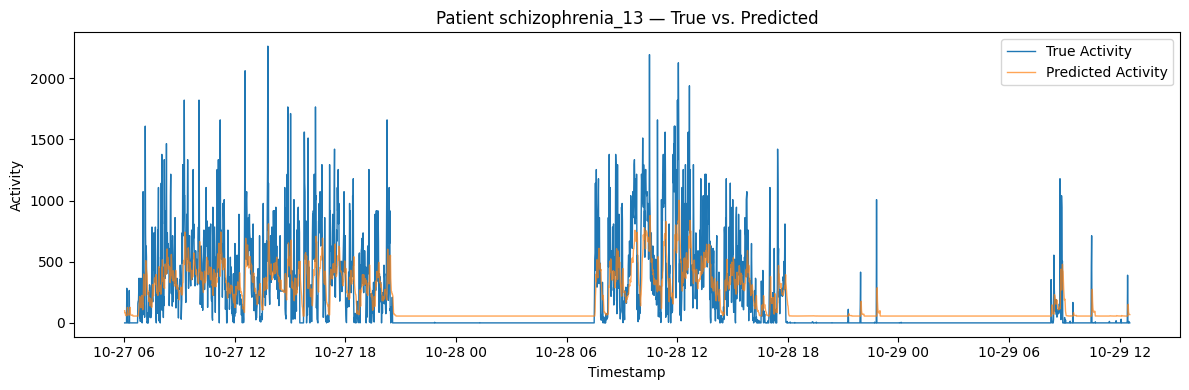

In [6]:
test_df = X_test.copy()
test_df['y']         = y_test.values
test_df['timestamp'] = t_test.values

pid = random.choice(test_df['patient_id'].unique())
grp = test_df[test_df['patient_id'] == pid].sort_values('timestamp')
feats = grp.drop(columns=['patient_id','timestamp','y']).values.astype(np.float32)
yvals = grp['y'].values
times = grp['timestamp'].values


x_windows = []
t_plot    = []
for i in range(WINDOW_SIZE, len(feats)):
    x_windows.append(feats[i-WINDOW_SIZE:i].flatten())
    t_plot.append(times[i])
x_windows = torch.from_numpy(np.stack(x_windows)).to(device)

with torch.no_grad():
    y_pred_s = model(x_windows).cpu().numpy()

y_pred = activity_scaler.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
y_true = activity_scaler.inverse_transform(yvals[WINDOW_SIZE:].reshape(-1,1)).flatten()

plt.figure(figsize=(12,4))
plt.plot(t_plot, y_true, label='True Activity', linewidth=1)
plt.plot(t_plot, y_pred, label='Predicted Activity', linewidth=1, alpha=0.7)
plt.title(f'Patient {pid} — True vs. Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Activity')
plt.legend()
plt.tight_layout()
plt.show()